0. Import modules

In [7]:
from palmerpenguins import load_penguins
from typing import List, Tuple, Any
from torch import tensor, float32, eye
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, LeakyReLU, Dropout, Sequential
from torch import Tensor
from torch.nn import BCELoss
from torchvision.models import resnet50,ResNet50_Weights
from torch.optim import Adam
from typing import Dict
from numpy import mean
from torch import no_grad
from time import perf_counter
from pandas import DataFrame
import matplotlib.pyplot as plt
from numpy import linspace
from torch import no_grad



1. Import dataset from the palmerpenguins module

In [8]:

data = load_penguins()
print(data.describe())
print(data.keys())

       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
count      342.000000     342.000000         342.000000   342.000000   
mean        43.921930      17.151170         200.915205  4201.754386   
std          5.459584       1.974793          14.061714   801.954536   
min         32.100000      13.100000         172.000000  2700.000000   
25%         39.225000      15.600000         190.000000  3550.000000   
50%         44.450000      17.300000         197.000000  4050.000000   
75%         48.500000      18.700000         213.000000  4750.000000   
max         59.600000      21.500000         231.000000  6300.000000   

              year  
count   344.000000  
mean   2008.029070  
std       0.818356  
min    2007.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2009.000000  
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')


2. Make a PyTorch dataset ``torch.utils.data.Dataset``

In [9]:
class PenguinDataset(Dataset):
    """Penguin dataset class.

    Parameters
    ----------
    input_keys : List[str]
        The column titles to use in the input feature vectors.
    target_keys : List[str]
        The column titles to use in the target feature vectors.
    train : bool
        If ``True``, this object will serve as the training set, and if
        ``False``, the validation set.

    Notes
    -----
    The validation split contains 10 male and 10 female penguins of each
    species.

    """

    def __init__(
        self,
        input_keys: List[str],
        target_keys: List[str],
        train: bool,
    ):
        """Build ``PenguinDataset``."""
        self.input_keys = input_keys
        self.target_keys = target_keys

        data = load_penguins()
        data = (
            data.loc[~data.isna().any(axis=1)]
            .sort_values(by=sorted(data.keys()))
            .reset_index(drop=True)
        )
        # Transform the sex field into a float, with male represented by 1.0, female by 0.0
        data.sex = (data.sex == "male").astype(float)
        self.full_df = data

        valid_df = self.full_df.groupby(by=["species", "sex"]).sample(
            n=10,
            random_state=123,
        )
        # The training items are simply the items *not* in the valid split
        train_df = self.full_df.loc[~self.full_df.index.isin(valid_df.index)]

        self.split = {"train": train_df, "valid": valid_df}[
            "train" if train is True else "valid"
        ]

    def __len__(self) -> int:
        """Return the length of requested split.

        Returns
        -------
        int
            The number of items in the dataset.

        """
        return len(self.split)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """Return an input-target pair.

        Parameters
        ----------
        idx : int
            Index of the input-target pair to return.

        Returns
        -------
        in_feats : Any
            Inputs.
        target : Any
            Targets.

        """
        # get the row index (idx) from the dataframe and
        # select relevant column features (provided as input_keys)
        feats = tuple(self.split.iloc[idx][self.input_keys])

        # this gives a 'species' i.e. one of ('Gentoo',), ('Chinstrap',), or ('Adelie',)
        tgts = tuple(self.split.iloc[idx][self.target_keys])

        # Task 4 - Exercise #1: convert the features to PyTorch Tensors
        feats = tensor(feats, dtype=float32)

        # Task 4 - Exercise #2: convert target to a 'one-hot' vector.
        target_names = sorted(self.full_df.species.unique())
        #make a 3x3 identity matrix and then index the target names to the vector position
        tgts = eye(len(target_names))[target_names.index(tgts[0])]

        return feats, tgts

3. Make a training and validation dataset

In [22]:
features = [
    "bill_length_mm",
    "bill_depth_mm",
    "body_mass_g",
    "flipper_length_mm",
    "sex"
]

target_names = sorted(data.species.unique())

data_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
)

for _, (input_feats, target) in zip(range(20), data_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  46.5000,   13.5000, 4550.0000,  210.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  44.0000,   13.6000, 4350.0000,  208.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  40.9000,   13.7000, 4650.0000,  214.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  42.6000,   13.7000, 4950.0000,  213.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  42.7000,   13.7000, 3950.0000,  208.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  45.3000,   13.7000, 4300.0000,  210.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  47.2000,   13.7000, 4925.0000,  214.0000,    0.0000]) t

4. Apply transforms to convert the data from tuples of numbers to ``torch.Tensor``s

In [25]:
# Apply transforms we need to PenguinDataset to convert input data and target class to tensors. 

# Create train_set
train_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
)

# Create valid_set
valid_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=False,
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor([0., 0., 1.])


5. Creating Dataloaders

In [27]:
batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
#data shuffled in the training set

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)
#data not shuffled in the validation set

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)
    #print(batch,targets)

torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([12, 5]) torch.Size([12, 3])


6. Create a neural network

In [13]:
class FCNet(Module):
    """Fully-connected neural network.

    Parameters
    ----------
    in_feats : int
        The number of input features to the model.
    out_feats : int
        The number of output features (or classes) the model should produce.

    """

    def __init__(self, in_feats: int, out_feats: int):
        """Build the neural network. - Define the structure of neural net"""
        super().__init__()
        self._fwd_seq = Sequential(
            BatchNorm1d(in_feats),
            Linear(in_feats, 16), #linear layer
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1), #activation function that looks like this -/
            Linear(16, 16), #linear layer
            BatchNorm1d(16),
            Dropout(0.1),
            LeakyReLU(0.1),
            Linear(16, out_feats), #linear layer
        )


    def forward(self, batch: Tensor) -> Tensor:
        """Pass ``batch`` through the model.

        Parameters
        ----------
        batch : Tensor
            A mini-batch of inputs.

        Returns
        -------
        Tensor
            The result of passing ``batch`` through the model.

        Define how the data passes through the neural net

        """
        return self._fwd_seq(batch)


model = FCNet(len(features), len(target_names))
print(model)

#from torch import rand
#test_batch = rand(5,5)
#model(test_batch)

FCNet(
  (_fwd_seq): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [14]:
#more complex model
res =resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
res
#list(res.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/macintosh/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

7. Select a loss function and an optimizer

In [15]:
loss_func = BCELoss()
optimiser = Adam(model.parameters())

8. Training and optimization loops

In [16]:
def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : BCELoss
        Binary cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.


    """
    model.train()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in train_loader:
        #zero the gradients(otherwise gradients accumulate)
        optimiser.zero_grad()
        #run forward model and compute proxy probabilities over dimension 1 (columns of tensor) - want  to make sure they sum to 1
        preds = model(batch).softmax(dim=1)
        #compute loss e.g. pred = [0.2,0.7,0.1] and target = [0,1,0]
        loss = loss_func(preds, targets)
        #compute gradients
        loss.backward()
        #nudge parameters in direction of steepest descent
        optimiser.step()
        #at each step we append the batch level statistics to the dictionary
        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Training dataloader.
    loss_func : BCELoss
        Binary cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    """
    model.eval()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in valid_loader:
        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def batch_level_accuracy(preds: Tensor, targets: Tensor):
    """Compute the batch-level accuracy.

    Parameters
    ----------
    preds : Tensor
        The model's predictions.
    targets : Tensor
        The corresponding labels.

    Returns
    -------
    float
        The batch-level accuracy.

    """
    return (preds.argmax(dim=1) == targets.argmax(dim=1)).float().mean()


9. Training, extracting, and plotting metrics

In [17]:
epochs = 200
print_interval = 25


train_metrics, valid_metrics = [], []


for epoch in range(epochs):

    if epoch % print_interval == 0:
        if epoch != 0:
            print(
                f"Epoch {max(epoch - print_interval, 0)}-{epoch} time: {perf_counter() - tic:.6f} seconds"
            )
        tic = perf_counter()

    train_metrics.append(train_one_epoch(model, train_loader, optimiser, loss_func))

    valid_metrics.append(validate_one_epoch(model, valid_loader, loss_func))

    stop_time = perf_counter()


print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)

metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")

print(metrics)

Epoch 0-25 time: 14.051657 seconds
Epoch 25-50 time: 13.445389 seconds
Epoch 50-75 time: 12.424995 seconds
Epoch 75-100 time: 10.971892 seconds
Epoch 100-125 time: 10.370422 seconds
Epoch 125-150 time: 11.094805 seconds
Epoch 150-175 time: 10.799545 seconds


     loss_train  accuracy_train  loss_valid  accuracy_valid
0      0.608802        0.411765    0.580159        0.437500
1      0.496199        0.735294    0.456099        0.927083
2      0.410535        0.930147    0.398621        0.953125
3      0.356885        0.952206    0.356047        0.953125
4      0.315877        0.937500    0.312494        0.953125
..          ...             ...         ...             ...
195    0.030884        0.981618    0.022177        0.984375
196    0.027654        0.988971    0.022663        1.000000
197    0.027184        0.992647    0.023033        0.984375
198    0.042426        0.977941    0.023747        0.984375
199    0.045179        0.974265    0.022935        0.984375

[200 rows x 4 colum

10. Visualise training results

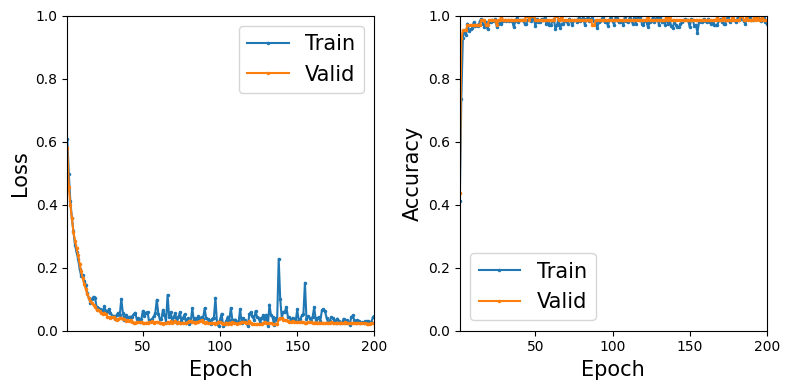

In [18]:
quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            ms=1.5,
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()

11. Run the NN on new inputs

In [19]:
# Construct a tensor of inputs to run the model over
demo_input = tensor(
    [
        [42.9, 13.1, 5000.0, 215.0, 0.0],
        [32.6, 11.3, 2000.0, 211.0, 1.0],
    ]
)
print(f"Raw input:\n{demo_input}\n")

# Place model in eval mode and run over inputs with no_grad
model.eval()
with no_grad():
    demo_output = model(demo_input).softmax(dim=1)

# Print the raw output from the net
print(f"Raw output:\n{demo_output}\n")

# Transform the raw output back to human-readable format
print(f"Predicted species:\n{[target_names[val.argmax()] for val in demo_output]}\n")

Raw input:
tensor([[4.2900e+01, 1.3100e+01, 5.0000e+03, 2.1500e+02, 0.0000e+00],
        [3.2600e+01, 1.1300e+01, 2.0000e+03, 2.1100e+02, 1.0000e+00]])

Raw output:
tensor([[6.2308e-06, 9.7501e-07, 9.9999e-01],
        [9.2132e-01, 4.6644e-06, 7.8674e-02]])

Predicted species:
['Gentoo', 'Adelie']

